In [1]:
# Mount "My Drive" into /content/drive
from google.colab import drive

google_drive_dir = "Final_Project_DL"  # @param
#bml-notebooks/
drive.mount('/content/drive')

mount_point = "/content/drive/MyDrive/{}".format(google_drive_dir)

# Change the root directory to your mount_point
%cd '$mount_point'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1BOvFtzoVhfYNe70lBGxYzhPlDElSrazo/Final_Project_DL


# <span style="color: royalblue;">Load Data</span>
Load the image data with labels.

In [2]:
import numpy as np
from src.loadData import loadFer2013
from keras.utils import to_categorical


In [3]:
emotions = {0: 'Angry', 1:'Disgust', 2:'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
class_names = list(emotions.values())
class_names

['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [4]:
X_train,X_val,X_test,y_train,y_val,y_test = loadFer2013('fer2013/icml_face_data.csv')

y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

In [5]:
X_train.shape

(28623, 48, 48)

#Overview

In [ ]:
import pandas as pd

df = pd.read_csv('fer2013/icml_face_data.csv')
df[df.Usage=='Training']

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
28704,2,Training,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,0,Training,114 112 113 113 111 111 112 113 115 113 114 11...
28706,4,Training,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,0,Training,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


In [ ]:
with open('fer2013/preprocessed_fer2013.txt','r') as f:
    inds = f.readlines()
print(inds[:5])

SyntaxError: ignored

In [ ]:
!rm -r fer2013/removed_img/*.png 

(-0.5, 47.5, 47.5, -0.5)

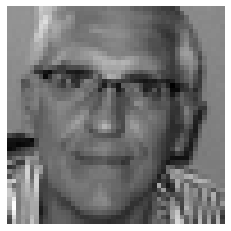

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

id = 4148
img = np.fromstring(df.pixels[id],sep=' ',dtype=np.uint8).reshape(48,48)
plt.imshow(img,cmap='gray')
plt.axis('off')

In [ ]:
import matplotlib.pyplot as plt

ids = [int(p.strip().split(',')[-1]) for p in inds]

for id in ids:
    arr = np.fromstring(df.pixels[id],sep=' ',dtype=np.uint8).reshape(48,48)
    plt.imsave('fer2013/removed_img/{}.png'.format(id),arr)
# plt.figure(num=87)
# plt.subplot(1,1,1)
# plt.imshow(np.fromstring(df.pixels[5439],sep=' ',dtype=np.uint8).reshape(48,48))
# plt.subplot(2,1,1)
# plt.imshow(np.fromstring(df.pixels[6458],sep=' ',dtype=np.uint8).reshape(48,48))
# plt.imsave()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1
    df_array2['emotion'] = array2
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index())
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [ ]:
plot_compare_distributions(y_train, y_val, title1='train labels', title2='val labels')

#Imbalance Data

In [6]:
import imblearn

if imblearn.__version__.split('.')[1] != '7':
   !pip install -U imbalanced-learn

In [7]:
def SMOTE_data(X_train,y_train,mode='smote'):
    if mode=='random':
        oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='auto')
    else:
        oversample = imblearn.over_sampling.SMOTE()

    X_train = X_train.reshape(X_train.shape[0], -1)

    X_train, y_train = oversample.fit_resample(X_train, y_train)

    X_train = X_train.reshape((X_train.shape[0], 48, 48))

    return X_train, y_train

In [8]:
X_train_smote,y_train_smote= SMOTE_data(X_train,y_train,mode='random')
y_train_onehot = to_categorical(y_train_smote)

#Preprocessing

In [9]:
def preprocessX(X):
    # X = X.astype(np.float32)
    # X = (X - X.mean())/X.std()
    return np.expand_dims(X,axis=-1)

X_processed_train = preprocessX(X_train_smote)
X_processed_val = preprocessX(X_val)
X_processed_test = preprocessX(X_test)
X_processed_train.shape,X_processed_val.shape,X_processed_test.shape

((50351, 48, 48, 1), (3589, 48, 48, 1), (3589, 48, 48, 1))

#Training

In [10]:
import keras
from keras.preprocessing import image
from keras import applications as keras_applications

In [11]:
!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git

     |████████████████████████████████| 51kB 6.1MB/s 
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-52ormp22
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-52ormp22
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=4e5a480f7f168f4c80c398608cefb635bdd3b2c8f9b67820470b96c61ae0f876
  Stored in directory: /tmp/pip-ephem-wheel-cache-zbhppw7s/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [12]:
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

In [13]:
from copy import deepcopy as copy

def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2, 'input should be a batch of one-hot-encoded data'
    y2 = copy(y)
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y2 *= 1 - smooth_factor
        y2 += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y2

In [15]:
from keras.utils import Sequence
from keras.utils import to_categorical
import cv2
from math import floor

class data_sequence(Sequence):
    '''
      yield sequence of data
      features -- list of features
      labels -- list of labels
      target_channels {int} -- 1 (gray) or 3(RGB)
    '''
    def __init__(self, features, labels, batch_size=128, target_dim=(224,224), 
                 n_classes=7, shuffle=True, smooth=0.0):
        'Initialization'
        assert len(features)==len(labels), 'number of feature and labels not consistent'
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.target_dim = target_dim
        self.target_channels = 3
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.smooth = smooth
        self.sample_count = len(labels)
        self.indexes = np.arange(self.sample_count)
        self.on_epoch_end()
#         self.verbose = verbose

    def __len__(self):
        'Denotes the number of batches per epoch'
        return floor(self.sample_count / self.batch_size)

    def __gray2RGB__(self,x):
      if len(x.shape)==2:
        return np.stack((x,x,x),-1)
      else:
        assert len(x.shape)==3
        if len(x[0,0,:]) == 1:
          return np.stack((x[:,:,0],x[:,:,0],x[:,:,0]),-1)
        else:
          assert len(x[0,0,:])==self.target_channels
      return x


    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, *self.target_dim, self.target_channels))
        Y = np.empty((self.batch_size, self.n_classes))
        for i,ind in enumerate(indexes):
          x = self.features[ind]
          # resize image to the target size 
          x = cv2.resize(x,self.target_dim,interpolation=cv2.INTER_CUBIC)
          x = self.__gray2RGB__(x)
          X[i] = utils.preprocess_input(x, version=2) # or version=2 for VGGFace2 ResNet50  
          y = self.labels[ind]
          if isinstance(y,int):
            Y[i]=to_categorical(y,7)
          else:
            assert len(y)==self.n_classes
            Y[i]=y
        X = np.array(X)
        Y = np.array(Y)
        if self.smooth > 0.0:
          smooth_labels(Y, self.smooth)
        return X,Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

#Model

In [16]:
vggmodel = keras.models.load_model('pretrained_model/VGGfaceTransfer_dropout_smoothing_keras_model')
# vggmodel = keras.models.Model(vggmodel.inputs, vggmodel.layers[-2].output)

In [17]:
train_sequence = data_sequence(X_processed_train,y_train_onehot,batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.07)
val_sequence   = data_sequence(X_processed_val,  y_val_onehot,  batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.0)
test_sequence  = data_sequence(X_processed_test, y_test_onehot, batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True,smooth=0.0)

In [ ]:
vggmodel.layers[0].trainable = False
vggmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classifer (Dense)            (None, 7)                 7

In [ ]:
vggmodel.compile(optimizer = keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
hist2 = vggmodel.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 20)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
786/786 [==============================] - 158s 198ms/step - loss: 0.4835 - accuracy: 0.8489 - val_loss: 1.1850 - val_accuracy: 0.6406
Epoch 2/20
786/786 [==============================] - 154s 195ms/step - loss: 0.3484 - accuracy: 0.8802 - val_loss: 1.2824 - val_accuracy: 0.6498
Epoch 3/20
786/786 [==============================] - 154s 195ms/step - loss: 0.3238 - accuracy: 0.8911 - val_loss: 1.2949 - val_accuracy: 0.6521
Epoch 4/20
786/786 [==============================] - 154s 195ms/step - loss: 0.2861 - accuracy: 0.9020 - val_loss: 1.3020 - val_accuracy: 0.6537
Epoch 5/20
786/786 [==============================] - 154s 195ms/step - loss: 0.2755 - accuracy: 0.9069 - val_loss: 1.3173 - val_accuracy: 0.6540
Epoch 6/20
786/786 [==============================] - 154s 195ms/step - loss: 0.2511 - accuracy: 0.9158 - val_loss: 1.3146 - val_accuracy: 0.6618
Epoch 7/20
786/786 [==============================] - 154s 196ms/step - loss: 0.2415 - accuracy: 0.9188 - val_loss: 1.3306 -

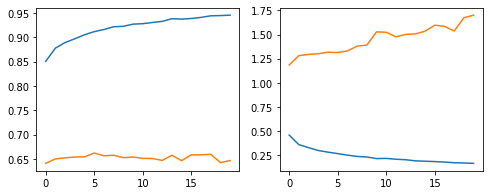

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])

In [ ]:
vggmodel.save('saved_model/vggface2_lr001_removed_hist.h5')

### finetune all layer, lr=1e-4

In [ ]:
vggmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classifer (Dense)            (None, 7)                 7

In [ ]:
for layer in vggmodel.layers[0].layers:
    if 'bn' not in layer.name:
        layer.trainable = True

In [ ]:
vggmodel.compile(optimizer = keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hist = vggmodel.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 10)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
786/786 [==============================] - 157s 197ms/step - loss: 0.1291 - accuracy: 0.9581 - val_loss: 1.6835 - val_accuracy: 0.6585
Epoch 2/10
786/786 [==============================] - 154s 195ms/step - loss: 0.0939 - accuracy: 0.9683 - val_loss: 1.7320 - val_accuracy: 0.6602
Epoch 3/10
786/786 [==============================] - 154s 195ms/step - loss: 0.0894 - accuracy: 0.9705 - val_loss: 1.7523 - val_accuracy: 0.6585
Epoch 4/10
786/786 [==============================] - 154s 196ms/step - loss: 0.0832 - accuracy: 0.9712 - val_loss: 1.7576 - val_accuracy: 0.6616
Epoch 5/10
786/786 [==============================] - 154s 196ms/step - loss: 0.0743 - accuracy: 0.9744 - val_loss: 1.7887 - val_accuracy: 0.6618
Epoch 6/10
786/786 [==============================] - 154s 196ms/step - loss: 0.0710 - accuracy: 0.9756 - val_loss: 1.8072 - val_accuracy: 0.6638
Epoch 7/10
786/786 [==============================] - 154s 196ms/step - loss: 0.0729 - accuracy: 0.9751 - val_loss: 1.8027 -

In [ ]:
for key in ['accuracy','val_accuracy','loss','val_loss']:
    hist.history[key] = hist2.history[key] + hist.history[key]

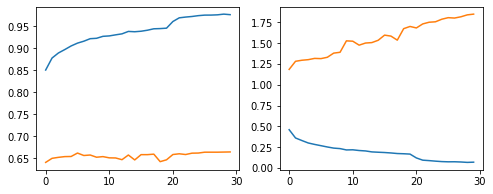

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

### finetune further all, lr=1e-5

In [ ]:
ls saved_checkpoint/Checkpoint/

In [ ]:
from keras.callbacks import ModelCheckpoint
check_point = ModelCheckpoint('saved_checkpoint/Checkpoint/VGGfaceTransfer_histequal.h5', 
                              monitor='val_acc', verbose=0, save_best_only=True,
                              save_weights_only=False, mode='auto', period=1)


vggmodel.compile(optimizer = keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
hist3 = vggmodel.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 10,
                            callbacks=[check_point])

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


786/786 [==============================] - 157s 197ms/step - loss: 0.0542 - accuracy: 0.9812 - val_loss: 2.0022 - val_accuracy: 0.6610
Epoch 2/10
786/786 [==============================] - 154s 195ms/step - loss: 0.0601 - accuracy: 0.9785 - val_loss: 1.9963 - val_accuracy: 0.6629
Epoch 3/10
786/786 [==============================] - 154s 195ms/step - loss: 0.0561 - accuracy: 0.9804 - val_loss: 1.9420 - val_accuracy: 0.6616
Epoch 4/10
786/786 [==============================] - 154s 195ms/step - loss: 0.0591 - accuracy: 0.9787 - val_loss: 1.9446 - val_accuracy: 0.6624
Epoch 5/10
786/786 [==============================] - 154s 196ms/step - loss: 0.0543 - accuracy: 0.9807 - val_loss: 1.9644 - val_accuracy: 0.6599
Epoch 6/10
786/786 [==============================] - 154s 195ms/step - loss: 0.0532 - accuracy: 0.9819 - val_loss: 1.9756 - val_accuracy: 0.6588
Epoch 7/10
786/786 [==============================] - 154s 195ms/step - loss: 0.0562 - accuracy: 0.9806 - val_loss: 1.9647 - val_accura

In [ ]:
ls

challenges-in-representation-learning-facial-expression-recognition-challenge.zip
example_submission.csv
fer2013/
fer2013.tar.gz
icml_face_data.csv
sample_data/
test.csv
train.csv


In [ ]:
for key in ['accuracy','val_accuracy','loss','val_loss']:
    hist.history[key] = hist.history[key] + hist3.history[key]

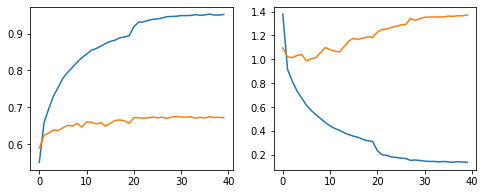

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

#Test

In [18]:
vggmodel.evaluate(val_sequence)

56/56 [==============================] - 18s 168ms/step - loss: 1.6790 - accuracy: 0.6761


[1.6790225505828857, 0.6760602593421936]

In [19]:
vggmodel.evaluate(test_sequence)

56/56 [==============================] - 10s 170ms/step - loss: 1.4838 - accuracy: 0.6981


[1.483811616897583, 0.6981026530265808]